# Flight Delay Prediction Model

This notebook explores the FAA flight dataset to build a linear regression model that predicts the probability of flight delays based on the day of the week and airport. The notebook will:

1. Load and explore the dataset
2. Cleanse the data by handling null values
3. Create a model to predict flight delays
4. Export the model for external use
5. Generate a CSV file with airport IDs and names

In [5]:
# Import required libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# For saving the model
import joblib

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme()

# For reproducibility
np.random.seed(42)


## Load and Explore the Dataset

Let's load the flight data from the CSV file and examine its structure.

In [6]:
# Load the flight data from CSV file
file_path = 'data/flights.csv'
flights_df = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
print(f"Dataset shape: {flights_df.shape}")
flights_df.head()


Dataset shape: (271940, 20)


,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,DestAirportName,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,John F. Kennedy International,New York,NY,1539,4,0.0,1824,13,0,0
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,Chicago Midway International,Chicago,IL,710,3,0.0,740,22,1,0
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,Ronald Reagan Washington National,Washington,DC,810,-3,0.0,1614,-7,0,0
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,Cleveland-Hopkins International,Cleveland,OH,804,35,1.0,1027,33,1,0
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,Hartsfield-Jackson Atlanta International,Atlanta,GA,545,-1,0.0,728,-9,0,0


In [7]:
# Get information about the dataset including data types and null values
flights_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271940 entries, 0 to 271939
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               271940 non-null  int64  
 1   Month              271940 non-null  int64  
 2   DayofMonth         271940 non-null  int64  
 3   DayOfWeek          271940 non-null  int64  
 4   Carrier            271940 non-null  object 
 5   OriginAirportID    271940 non-null  int64  
 6   OriginAirportName  271940 non-null  object 
 7   OriginCity         271940 non-null  object 
 8   OriginState        271940 non-null  object 
 9   DestAirportID      271940 non-null  int64  
 10  DestAirportName    271940 non-null  object 
 11  DestCity           271940 non-null  object 
 12  DestState          271940 non-null  object 
 13  CRSDepTime         271940 non-null  int64  
 14  DepDelay           271940 non-null  int64  
 15  DepDel15           269179 non-null  float64
 16  CR

In [8]:
# Get descriptive statistics of the dataset
flights_df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year,271940.0,NaN,NaN,NaN,2013.0,0.0,2013.0,2013.0,2013.0,2013.0,2013.0
Month,271940.0,NaN,NaN,NaN,6.978514,1.982431,4.0,5.0,7.0,9.0,10.0
DayofMonth,271940.0,NaN,NaN,NaN,15.814775,8.799033,1.0,8.0,16.0,23.0,31.0
DayOfWeek,271940.0,NaN,NaN,NaN,3.899316,1.987219,1.0,2.0,4.0,6.0,7.0
Carrier,271940,16,WN,57861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginAirportID,271940.0,NaN,NaN,NaN,12744.899584,1501.199773,10140.0,11292.0,12892.0,14057.0,15376.0
OriginAirportName,271940,70,Hartsfield-Jackson Atlanta International,15119,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginCity,271940,66,Chicago,17918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginState,271940,36,CA,38352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DestAirportID,271940.0,NaN,NaN,NaN,12739.136493,1502.569949,10140.0,11292.0,12892.0,14057.0,15376.0


## Data Cleansing

Let's identify and handle null values in the dataset. According to the requirements, we'll replace null values with zero.

In [9]:
# Check for null values in each column
null_counts = flights_df.isnull().sum()
print("Columns with null values:")
print(null_counts[null_counts > 0])


Columns with null values:
DepDel15    2761
dtype: int64


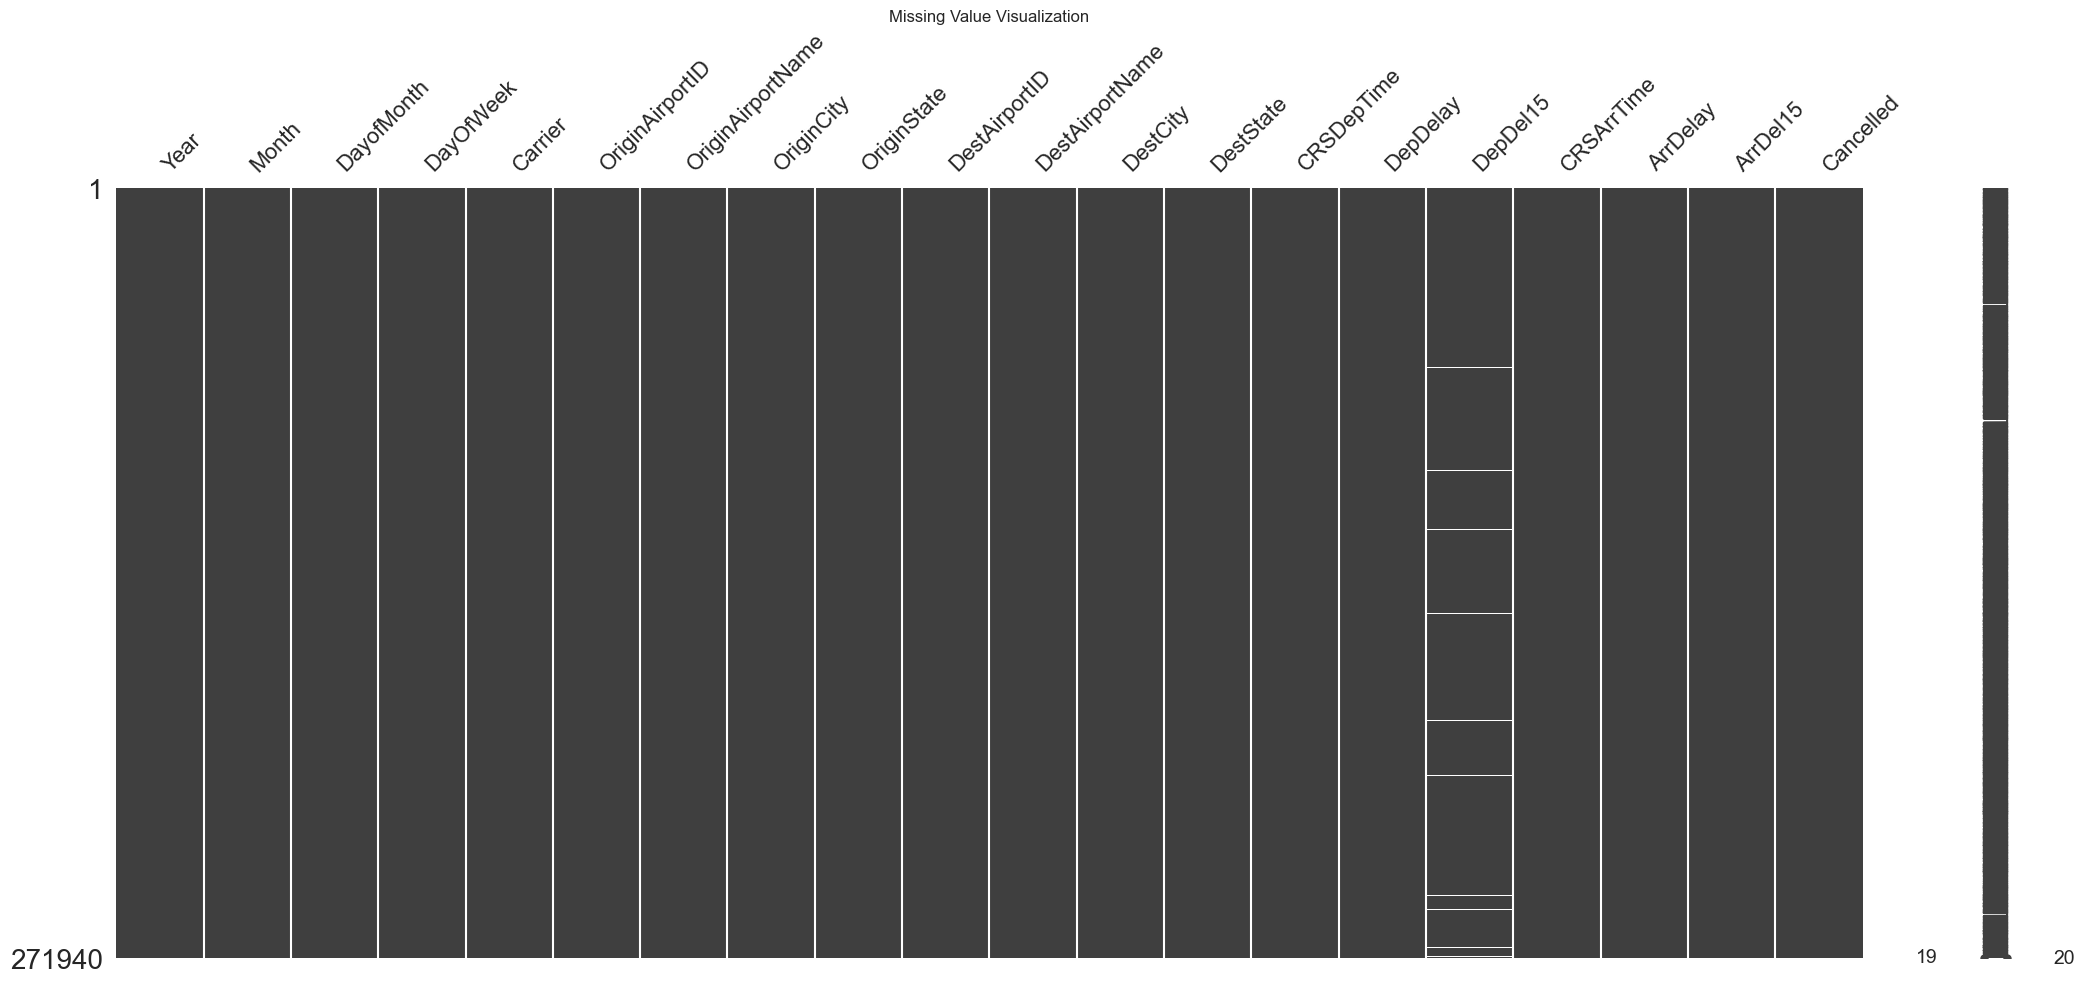

In [13]:
# Visualize missing values
import missingno as msno
msno.matrix(flights_df)
plt.title('Missing Value Visualization')
plt.show()


In [14]:
# Replace null values with zero as per requirements
flights_df_clean = flights_df.fillna(0)

# Verify no more null values exist
print("Columns with null values after cleaning:")
print(flights_df_clean.isnull().sum()[flights_df_clean.isnull().sum() > 0])

# If the output is empty, it means there are no more null values


Columns with null values after cleaning:
Series([], dtype: int64)


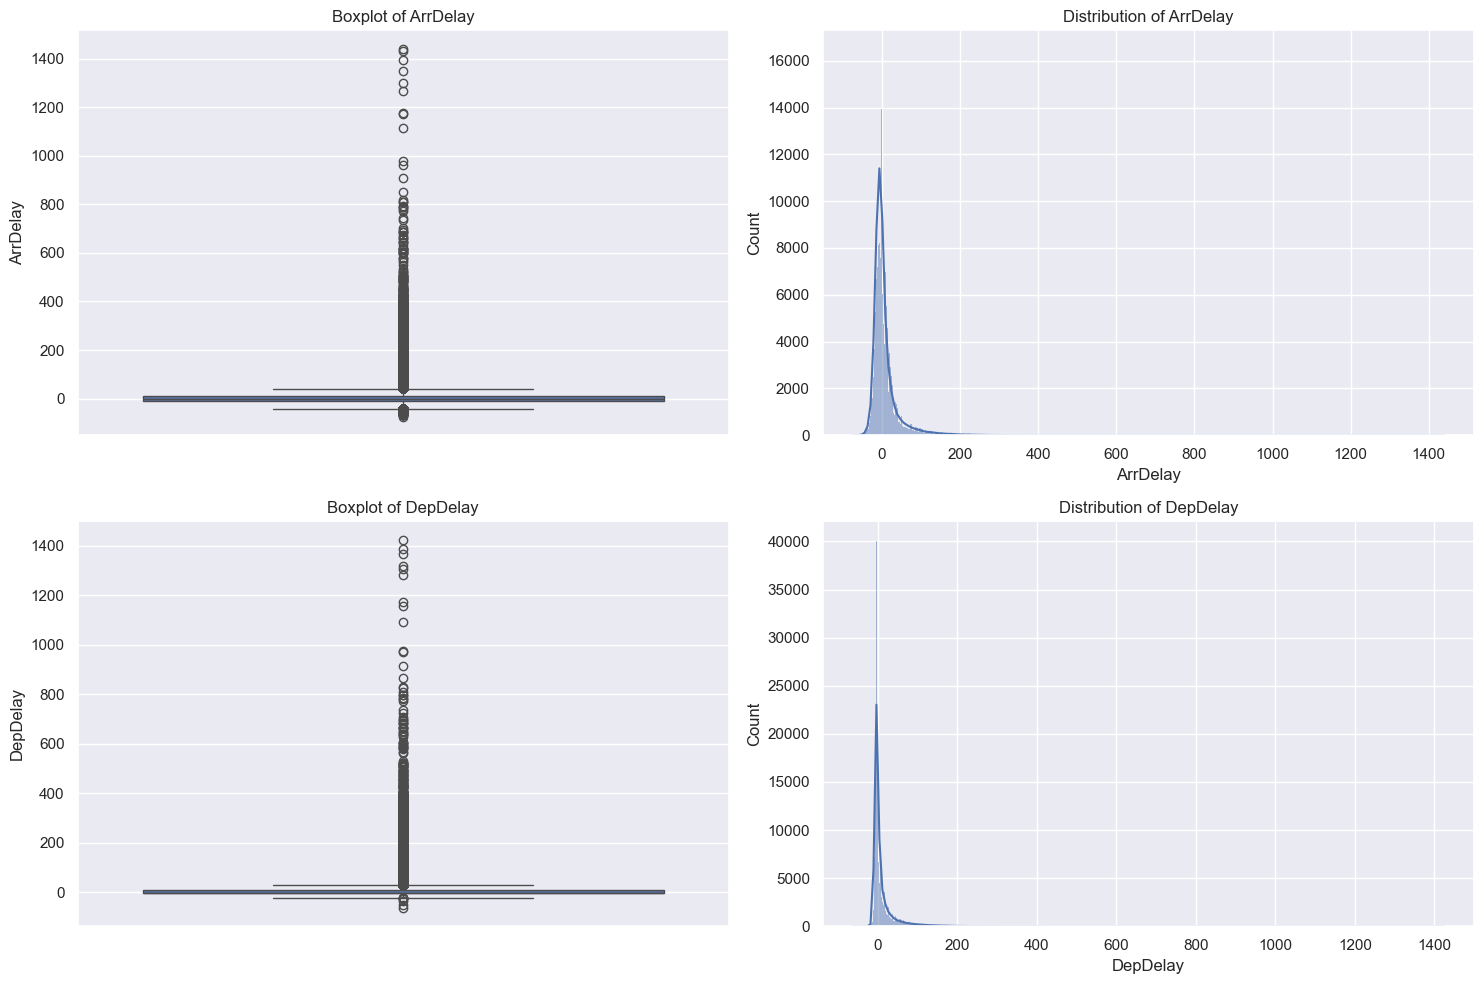


Unique values for FL_DATE (first few):
<DatetimeArray>
['2013-09-16 00:00:00', '2013-09-23 00:00:00', '2013-09-07 00:00:00',
 '2013-07-22 00:00:00', '2013-05-16 00:00:00']
Length: 5, dtype: datetime64[ns]

Unique values for Carrier:
['DL' 'WN' 'AS' 'OO' 'UA' 'EV' 'AA' 'MQ' 'US' 'YV' 'FL' 'F9' 'B6' 'VX'
 '9E' 'HA']

Unique values for CRSDepTime (first few):
[1539  710  810  804  545]


In [21]:
# Check for any weird or inconsistent values

# Look for potential outliers in numerical columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

columns = ['ArrDelay', 'DepDelay']
for i, column in enumerate(columns):
    # Boxplot
    sns.boxplot(y=flights_df_clean[column], ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {column}')
    # Histogram
    sns.histplot(flights_df_clean[column], ax=axes[i, 1], kde=True)
    axes[i, 1].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

# Check for invalid categorical values
# Construct FL_DATE column if it doesn't exist
if 'FL_DATE' not in flights_df_clean.columns:
    flights_df_clean['FL_DATE'] = pd.to_datetime(
        flights_df_clean[['Year', 'Month', 'DayofMonth']]
        .astype(str)
        .agg('-'.join, axis=1)
    )

print("\nUnique values for FL_DATE (first few):")
print(flights_df_clean['FL_DATE'].unique()[:5])

print("\nUnique values for Carrier:")
print(flights_df_clean['Carrier'].unique())

print("\nUnique values for CRSDepTime (first few):")
print(flights_df_clean['CRSDepTime'].unique()[:5])


In [22]:
# Convert date string to datetime object and extract day of week
flights_df_clean['FL_DATE'] = pd.to_datetime(flights_df_clean['FL_DATE'])
flights_df_clean['DAY_OF_WEEK'] = flights_df_clean['FL_DATE'].dt.dayofweek

# Map numeric day to name for better readability
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
          4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
flights_df_clean['DAY_NAME'] = flights_df_clean['DAY_OF_WEEK'].map(day_map)

# Display the first few rows with the new columns
flights_df_clean[['FL_DATE', 'DAY_OF_WEEK', 'DAY_NAME']].head()


,FL_DATE,DAY_OF_WEEK,DAY_NAME
0,2013-09-16,0,Monday
1,2013-09-23,0,Monday
2,2013-09-07,5,Saturday
3,2013-07-22,0,Monday
4,2013-05-16,3,Thursday


## Feature Engineering and Preparation

Now we'll prepare the features and target variable for the linear regression model. Based on the requirements, we need to:

1. Create features based on day of week and airport
2. Set the target variable as the delay flag (flights delayed more than 15 minutes)
3. Split the data into training and test sets

Delayed flights (>15 min): 53583
Non-delayed flights: 218357
Percentage of delayed flights: 19.70%


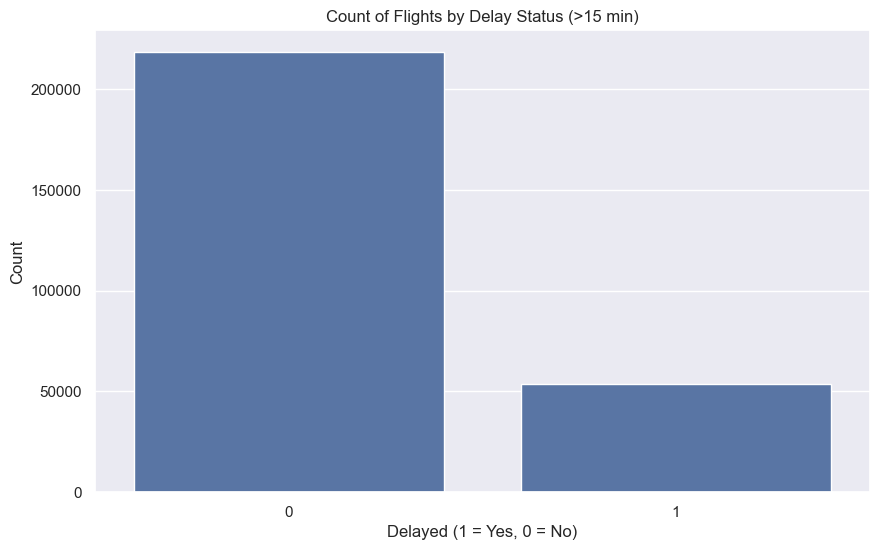

In [25]:
# Creating a binary target variable for delays over 15 minutes
# As per the instructions, we need to predict if a flight will be delayed by more than 15 minutes
# The dataset might already have this column as ARR_DEL15, but if not, we create it
if 'ARR_DEL15' not in flights_df_clean.columns:
    flights_df_clean['ARR_DEL15'] = (flights_df_clean['ArrDelay'] > 15).astype(int)

# Display counts of delayed vs non-delayed flights
print("Delayed flights (>15 min):", flights_df_clean['ARR_DEL15'].sum())
print("Non-delayed flights:", len(flights_df_clean) - flights_df_clean['ARR_DEL15'].sum())
print(f"Percentage of delayed flights: {flights_df_clean['ARR_DEL15'].mean()*100:.2f}%")

# Visualize the distribution of delays
plt.figure(figsize=(10, 6))
sns.countplot(x='ARR_DEL15', data=flights_df_clean)
plt.title('Count of Flights by Delay Status (>15 min)')
plt.xlabel('Delayed (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()


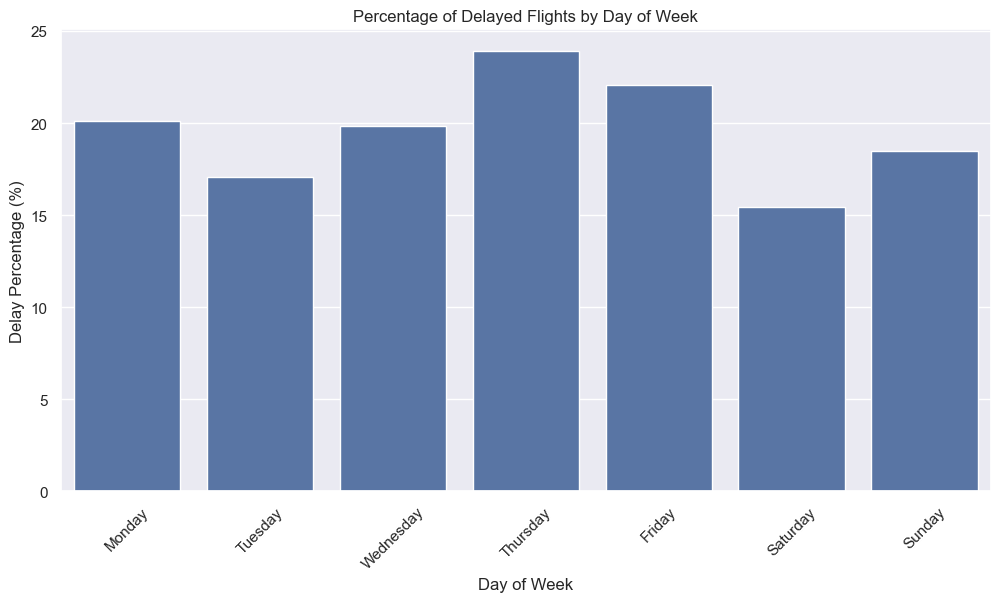

In [26]:
# Analyze how delays vary by day of week
day_delays = flights_df_clean.groupby('DAY_NAME')['ARR_DEL15'].mean().reset_index()
day_delays['ARR_DEL15'] = day_delays['ARR_DEL15'] * 100  # Convert to percentage

# Sort by day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_delays['DAY_NAME'] = pd.Categorical(day_delays['DAY_NAME'], categories=day_order, ordered=True)
day_delays = day_delays.sort_values('DAY_NAME')

# Plot delays by day of week
plt.figure(figsize=(12, 6))
sns.barplot(x='DAY_NAME', y='ARR_DEL15', data=day_delays)
plt.title('Percentage of Delayed Flights by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Delay Percentage (%)')
plt.xticks(rotation=45)
plt.show()


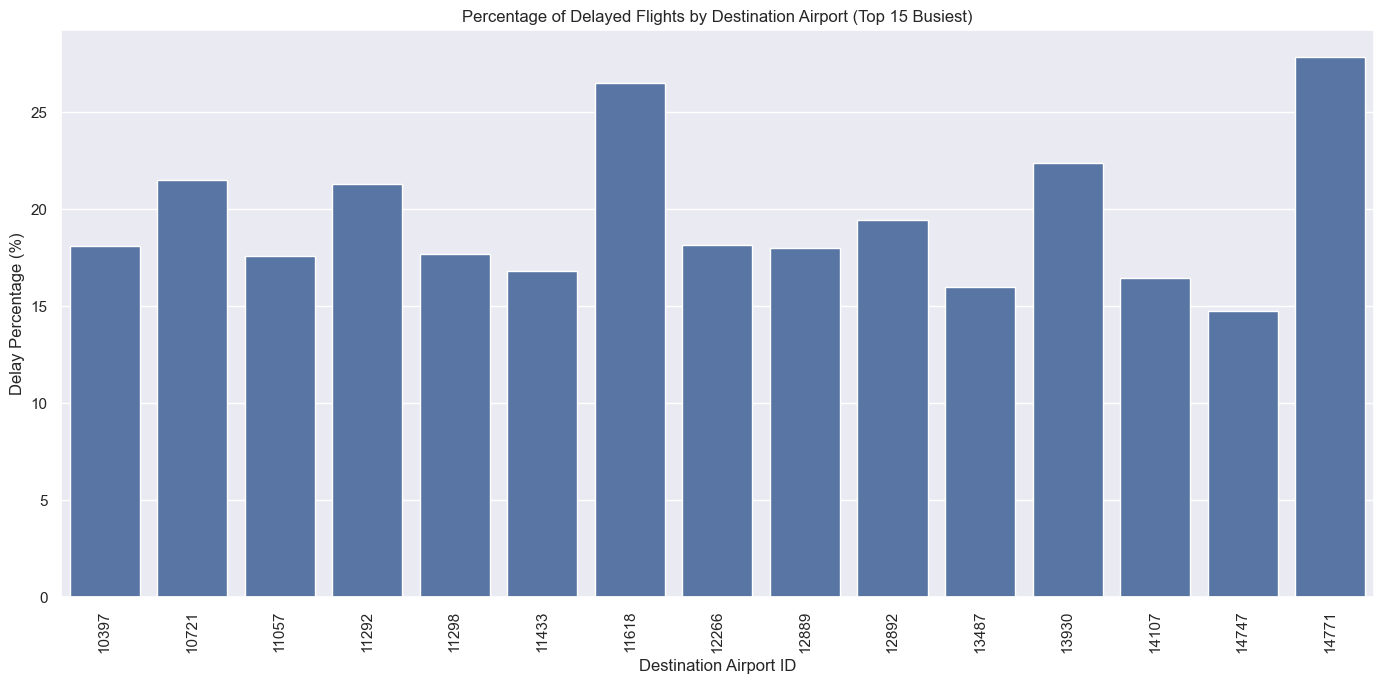

In [29]:
# Analyze how delays vary by destination airport
# First, get the airports with the most flights
top_airports = flights_df_clean['DestAirportID'].value_counts().nlargest(15).index.tolist()

# Calculate delay percentages for these airports
airport_delays = flights_df_clean[flights_df_clean['DestAirportID'].isin(top_airports)].groupby('DestAirportID')['ARR_DEL15'].mean().reset_index()
airport_delays['ARR_DEL15'] = airport_delays['ARR_DEL15'] * 100  # Convert to percentage
airport_delays = airport_delays.sort_values('ARR_DEL15', ascending=False)

# Plot delays by airport
plt.figure(figsize=(14, 7))
sns.barplot(x='DestAirportID', y='ARR_DEL15', data=airport_delays)
plt.title('Percentage of Delayed Flights by Destination Airport (Top 15 Busiest)')
plt.xlabel('Destination Airport ID')
plt.ylabel('Delay Percentage (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [32]:
# Prepare features for modeling
# We'll create dummy variables for day of week and airport

# Select relevant features: day of week and destination airport
X = flights_df_clean[['DAY_OF_WEEK', 'DestAirportID']]
y = flights_df_clean['ARR_DEL15']  # Target: Whether flight is delayed by >15 min

# Create dummy variables for categorical features
X_encoded = pd.get_dummies(X, columns=['DestAirportID'], drop_first=True)  
# We keep DAY_OF_WEEK as a numeric feature (0-6)

print(f"Shape of feature matrix after encoding: {X_encoded.shape}")
print(f"First 5 column names: {list(X_encoded.columns[:5])}...")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Shape of feature matrix after encoding: (271940, 70)
First 5 column names: ['DAY_OF_WEEK', 'DestAirportID_10299', 'DestAirportID_10397', 'DestAirportID_10423', 'DestAirportID_10529']...
Training set shape: (203955, 70)
Testing set shape: (67985, 70)


## Building the Linear Regression Model

Now we'll build a linear regression model to predict the probability of flight delays based on the day of week and destination airport.

In [33]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Sometimes linear regression can produce values outside [0,1] range
# Clip predictions to be between 0 and 1 for probability interpretation
y_pred_clipped = np.clip(y_pred, 0, 1)


Mean Squared Error: 0.1567
R² Score: 0.0064
Custom Accuracy: 80.38%


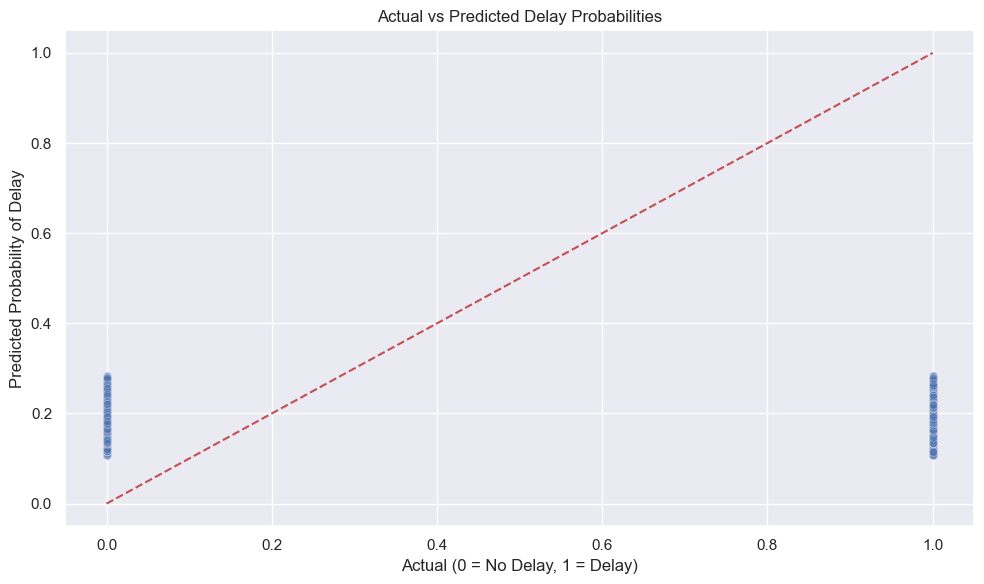

In [34]:
# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred_clipped)
r2 = r2_score(y_test, y_pred_clipped)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Calculate mean absolute percentage error for more interpretable results
def custom_accuracy(y_true, y_pred):
    """Calculate how often the model correctly predicts delay/no delay"""
    # Convert probabilities to binary predictions (threshold 0.5)
    y_pred_binary = (y_pred > 0.5).astype(int)
    return (y_pred_binary == y_true).mean() * 100

accuracy = custom_accuracy(y_test, y_pred_clipped)
print(f"Custom Accuracy: {accuracy:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_clipped, alpha=0.3)
plt.title('Actual vs Predicted Delay Probabilities')
plt.xlabel('Actual (0 = No Delay, 1 = Delay)')
plt.ylabel('Predicted Probability of Delay')

# Add a diagonal line for perfect predictions
plt.plot([0, 1], [0, 1], 'r--')
plt.tight_layout()
plt.show()


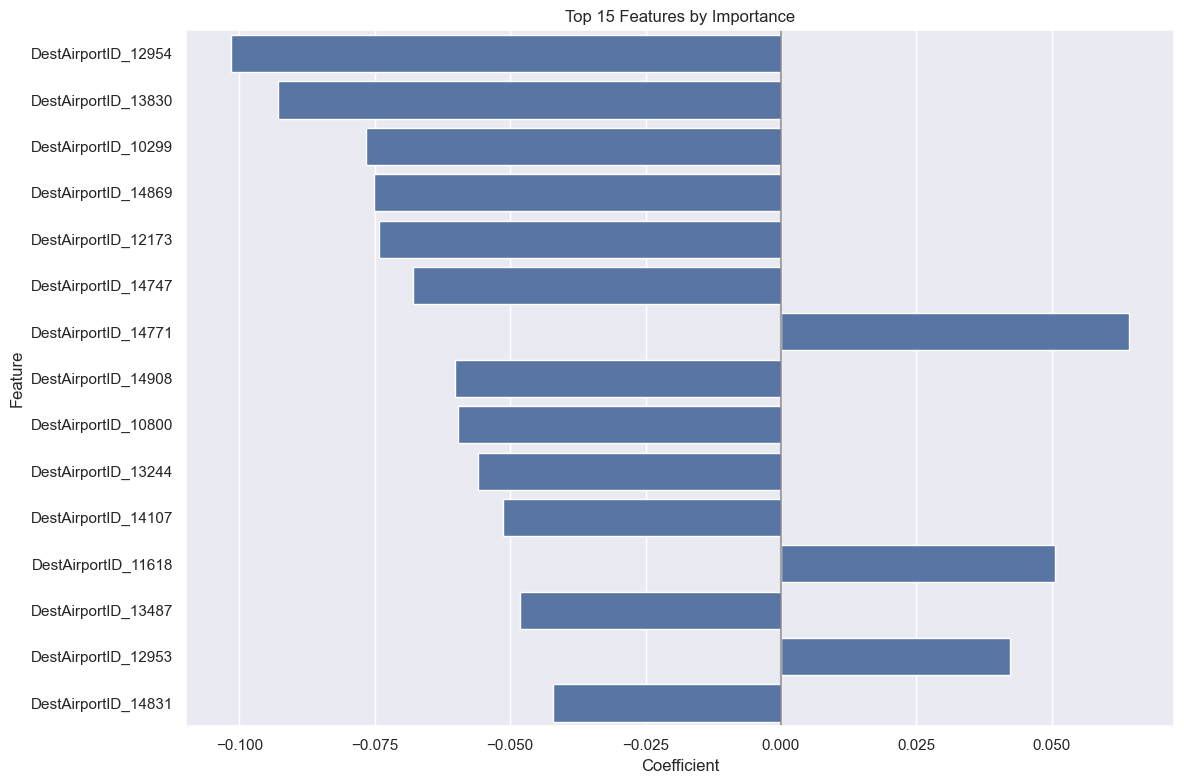

Baseline probability (intercept): 0.2178


In [35]:
# Analyze feature importance
feature_importances = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': model.coef_
})

# Sort by absolute coefficient value
feature_importances['Abs_Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values('Abs_Coefficient', ascending=False).head(15)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importances)
plt.title('Top 15 Features by Importance')
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the intercept (baseline probability)
print(f"Baseline probability (intercept): {model.intercept_:.4f}")


In [36]:
# Function to predict delay probability for a given day and airport
def predict_delay(day_of_week, destination_airport):
    """Predict the probability of delay for a given day and airport.
    
    Args:
        day_of_week: Integer 0-6 (0=Monday, 6=Sunday)
        destination_airport: String airport code
    
    Returns:
        Float probability of delay (0-1)
    """
    # Create a DataFrame with the specified day and airport
    input_data = pd.DataFrame({
        'DAY_OF_WEEK': [day_of_week],
        'DEST': [destination_airport]
    })
    
    # Encode it the same way we encoded our training data
    input_encoded = pd.get_dummies(input_data, columns=['DEST'], drop_first=True)
    
    # Make sure it has the same columns as our training data
    for col in X_encoded.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    
    # Keep only the columns that were used for training
    input_encoded = input_encoded[X_encoded.columns]
    
    # Make prediction
    delay_prob = model.predict(input_encoded)[0]
    
    # Clip to valid probability range
    return np.clip(delay_prob, 0, 1)

# Demonstrate the prediction function with a few examples
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Top airports from earlier analysis
for day in [0, 4, 6]:  # Monday, Friday, Sunday
    print(f"\nPredictions for {day_names[day]}:")
    for airport in top_airports[:5]:
        prob = predict_delay(day, airport)
        print(f"- {airport}: {prob*100:.2f}% chance of delay")



Predictions for Monday:
- 10397: 21.78% chance of delay
- 13930: 21.78% chance of delay
- 12892: 21.78% chance of delay
- 11298: 21.78% chance of delay
- 11292: 21.78% chance of delay

Predictions for Friday:
- 10397: 21.21% chance of delay
- 13930: 21.21% chance of delay
- 12892: 21.21% chance of delay
- 11298: 21.21% chance of delay
- 11292: 21.21% chance of delay

Predictions for Sunday:
- 10397: 20.92% chance of delay
- 13930: 20.92% chance of delay
- 12892: 20.92% chance of delay
- 11298: 20.92% chance of delay
- 11292: 20.92% chance of delay


## Save Model and Export Airport Data

Now we'll:
1. Save the trained model to a file for use in external applications
2. Create a CSV file with airport IDs and names for reference

In [37]:
# Save the trained model to a pickle file
model_filename = 'flight_delay_model.pkl'
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")

# Also save the feature columns to ensure consistent encoding when using the model
feature_columns_file = 'model_features.pkl'
joblib.dump(X_encoded.columns, feature_columns_file)

print(f"Feature columns saved to {feature_columns_file}")


Model saved to flight_delay_model.pkl
Feature columns saved to model_features.pkl


In [38]:
# Function to demonstrate how to load and use the model in an external application
def load_and_use_model(day_of_week, destination_airport):
    """Load the saved model and make a prediction.
    
    Args:
        day_of_week: Integer 0-6 (0=Monday, 6=Sunday)
        destination_airport: String airport code
        
    Returns:
        Float probability of delay (0-1)
    """
    # Load the saved model
    loaded_model = joblib.load(model_filename)
    
    # Load the feature columns
    feature_cols = joblib.load(feature_columns_file)
    
    # Create input data
    input_data = pd.DataFrame({
        'DAY_OF_WEEK': [day_of_week],
        'DEST': [destination_airport]
    })
    
    # Encode it
    input_encoded = pd.get_dummies(input_data, columns=['DEST'], drop_first=True)
    
    # Ensure it has all required columns
    for col in feature_cols:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    
    # Select only the needed columns in the right order
    input_encoded = input_encoded[feature_cols]
    
    # Make prediction
    prediction = loaded_model.predict(input_encoded)[0]
    
    return np.clip(prediction, 0, 1)

# Test that the loaded model works correctly
day = 0  # Monday
airport = top_airports[0]  # First airport in our list

original_prediction = predict_delay(day, airport)
loaded_prediction = load_and_use_model(day, airport)

print(f"Prediction using original model: {original_prediction:.4f}")
print(f"Prediction using loaded model: {loaded_prediction:.4f}")
print(f"Difference: {abs(original_prediction - loaded_prediction):.10f}")


Prediction using original model: 0.2178
Prediction using loaded model: 0.2178
Difference: 0.0000000000


In [41]:
# Create a DataFrame with all airports and their IDs
# In the flights dataset, airports are identified by their numeric IDs (e.g., 10397, 13930)

# First, gather airport info from origin and destination
dest_airports = flights_df_clean[['DestAirportID']].drop_duplicates().rename(columns={'DestAirportID': 'AIRPORT_ID'})
origin_airports = flights_df_clean[['OriginAirportID']].drop_duplicates().rename(columns={'OriginAirportID': 'AIRPORT_ID'})

# Combine both sets
all_airports = pd.concat([dest_airports, origin_airports]).drop_duplicates().reset_index(drop=True)

# Sort numerically
all_airports = all_airports.sort_values('AIRPORT_ID').reset_index(drop=True)

# Add a name column (in real applications, you might have a lookup table with full airport names)
# For this exercise, we'll just use the IDs as names
all_airports['AIRPORT_NAME'] = all_airports['AIRPORT_ID'].astype(str)

print(f"Total unique airports in the dataset: {len(all_airports)}")

# Display the first few rows
all_airports.head()


Total unique airports in the dataset: 70


,AIRPORT_ID,AIRPORT_NAME
0,10140,10140
1,10299,10299
2,10397,10397
3,10423,10423
4,10529,10529


In [42]:
# Save the airport information to a CSV file
airports_file = 'airports.csv'
all_airports.to_csv(airports_file, index=False)

print(f"Airport data saved to {airports_file}")


Airport data saved to airports.csv


## Summary

In this notebook, we have:

1. Loaded and explored the FAA flight dataset
2. Cleansed the data by identifying and replacing null values with zeros
3. Extracted day of week features and analyzed their relationship with flight delays
4. Built a linear regression model to predict the probability of flight delays based on day of week and airport
5. Evaluated the model's performance
6. Saved the model to a file for external use
7. Created a CSV file containing the list of all airports and their IDs

The model can now be used in an external application to predict the likelihood of a flight being delayed by more than 15 minutes for a specific day of the week and airport combination.